# Ghibli Film Text Generation
### Using LSTM in PyTorch to generate Ghibli film style text:
The goal of this mini-project is to use movie transcripts from the famous Ghibli animiation film studio and generate text in that style. We will use LSTM in PyTorch to generate the text (alternatively possible with TensorFlow as well). We'll use the four following movies to generate text: 

'Castle in the Sky (1986)', 'Howl's Moving Castle (2004)', 'Kiki's Delivery Service (1989)', and 'Spirited Away (2001)'.

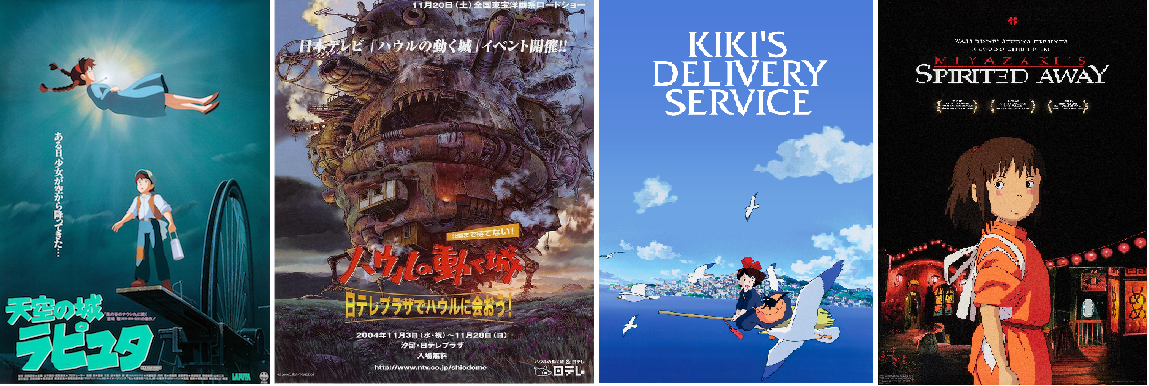

### Import Dependencies

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

The transcripts are saved separately for each movie. We need to load them in and clean/prepare the data to be used for the training model.

## Data Preprocessing

### 1. Load transcripts and combine into one text

In [36]:
filenames = ['Castle_In_The_Sky.txt', 'Howls_Moving_Castle.txt', 'Kiki_Delivery_Service.txt', 'Spirited_Away.txt']
raw_text = ''
for filename in filenames:
    raw_text+=open(filename, 'r', encoding='utf-8').read()
    
# convert text to lowercase
raw_text = raw_text.lower()

### 2. Map unique characters to integers
The model should use characters as floating point values to train and generate text data later. We'll map our text file from chars to integers for now.

In [37]:
# sort unique characters and map to integers
chars = sorted(list(set(raw_text)))
char_to_int = dict((c, i) for i, c in enumerate(chars))

Let's take a look to see what kind of character data we have. How many unique and total characters are in the text?

In [38]:
n_chars = len(raw_text)
n_vocab = len(chars)
print("Total Characters: ", n_chars)
print("Unique Characters: ", n_vocab)

Total Characters:  195908
Unique Characters:  62


Here we can see that despite having a large number of total characters (almost 20k), there are only 62 unique characters.

### 3. Sequencing, Train and Test data
LSTMs need data in 'sequences', where the integer mapped characters are broken into certain size chunks to predict the next character. For example, if we had the word 'hello' with a sequence length of 3, it would get broken into:

['h','e','l'], predicting for the next letter: 'l'

followed by ['e','l','l'] predicting for the next letter: 'o'.


In [40]:
# create train and test data
seq_length = 1000
dataX = []
dataY = []
for i in range(0, n_chars - seq_length, 1):
    seq_in = raw_text[i:i + seq_length]
    seq_out = raw_text[i + seq_length]
    dataX.append([char_to_int[char] for char in seq_in])
    dataY.append(char_to_int[seq_out])
n_seq = len(dataX)
print("Total Sequences: ", n_seq)

Total Sequences:  194908


Here we've created dataX, which has the chunks of length 100, predicting for the corresponding value in dataY, which contains the next character in the text. We'll use these two to train our text generator.

### 4. Reshape and change data to floating point
As mentioned before, the integer values should be converted to floating point to be used for text generation. We can also normalize the data (in the range 0 to 1) at this point. 

We also need dataX to be in the format of [samples, time steps, features], so we'll reshape it and create a pytorch tensor called X.

In [6]:
# reshape and change to floating point
X = torch.tensor(dataX, dtype=torch.float32).reshape(n_seq, seq_length, 1)
X = X / float(n_vocab)
y = torch.tensor(dataY)

In [7]:
print(X.shape, y.shape)

torch.Size([195808, 100, 1]) torch.Size([195808])


## Modeling 

### 1. Create model from PyTorch nn.Module
We'll now create the LSTM model. Here we'll try using an LSTM layer with 256 hidden units, followed by a dropout layer with a probability of 0.2, followed by a linear layer to map back to the 62 unique characters in the text.

In [8]:
class GhibliModel(nn.Module):
    def __init__(self):
        super().__init__()
        # lstm layer: 256 hidden units, 1 input for each individual character, one layer for now
        self.lstm = nn.LSTM(input_size=1, hidden_size=256, num_layers=1, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(256, n_vocab)
    def forward(self, x):
        x, _ = self.lstm(x)
        # take only the last output
        x = x[:, -1, :]
        # produce output
        x = self.linear(self.dropout(x))
        return x

### Find best model and save
Initial parameters are: 40 epochs, 128 characters per batch, Adam optimizer, CrossEntropyLoss as the loss function.

In [10]:
torch.cuda.is_available()

True

In [11]:
print(torch.version.cuda)

11.8


In [9]:
n_epochs = 50
batch_size = 128
model = GhibliModel()

# use gpu if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
 
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss(reduction="sum")
loader = data.DataLoader(data.TensorDataset(X, y), shuffle=True, batch_size=batch_size)
 
best_model = None
best_loss = np.inf
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch.to(device))
        loss = loss_fn(y_pred, y_batch.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    model.eval()
    loss = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            y_pred = model(X_batch.to(device))
            loss += loss_fn(y_pred, y_batch.to(device))
        if loss < best_loss:
            best_loss = loss
            best_model = model.state_dict()
        print("Epoch %d: Cross-entropy: %.4f" % (epoch, loss))
 
torch.save([best_model, char_to_int], "single-char.pth")

Epoch 0: Cross-entropy: 557397.1875
Epoch 1: Cross-entropy: 519346.6875
Epoch 2: Cross-entropy: 493365.4375
Epoch 3: Cross-entropy: 478032.7812
Epoch 4: Cross-entropy: 466128.6562
Epoch 5: Cross-entropy: 454464.7812
Epoch 6: Cross-entropy: 442087.8750
Epoch 7: Cross-entropy: 433390.5312
Epoch 8: Cross-entropy: 424152.8125
Epoch 9: Cross-entropy: 416916.3125
Epoch 10: Cross-entropy: 408407.2500
Epoch 11: Cross-entropy: 401994.6562
Epoch 12: Cross-entropy: 395410.4062
Epoch 13: Cross-entropy: 390027.3125
Epoch 14: Cross-entropy: 381833.7188
Epoch 15: Cross-entropy: 377535.9062
Epoch 16: Cross-entropy: 373405.1250
Epoch 17: Cross-entropy: 365599.1250
Epoch 18: Cross-entropy: 362161.8750
Epoch 19: Cross-entropy: 357369.1562
Epoch 20: Cross-entropy: 354553.0625
Epoch 21: Cross-entropy: 349101.4062
Epoch 22: Cross-entropy: 344555.7812
Epoch 23: Cross-entropy: 340368.2812
Epoch 24: Cross-entropy: 336773.7500
Epoch 25: Cross-entropy: 336408.2812
Epoch 26: Cross-entropy: 330206.4062
Epoch 27: C

## converge at around epoch 35

In [16]:
#torch.save([best_model, char_to_int], "single-char.pth")

In [26]:
best_model, char_to_int = torch.load("single-char.pth")
n_vocab = len(char_to_int)
int_to_char = dict((i, c) for c, i in char_to_int.items())
model.load_state_dict(best_model)

RuntimeError: Error(s) in loading state_dict for GhibliModel_2:
	Missing key(s) in state_dict: "lstm.weight_ih_l1", "lstm.weight_hh_l1", "lstm.bias_ih_l1", "lstm.bias_hh_l1". 

In [14]:
# randomly generate a prompt
filename = "Howls_Moving_Castle.txt"
seq_length = 1000
raw_text = open(filename, 'r', encoding='utf-8').read()
raw_text = raw_text.lower()
start = np.random.randint(0, len(raw_text)-seq_length)
prompt = raw_text[start:start+seq_length]
pattern = [char_to_int[c] for c in prompt]

In [15]:
model.eval()

GhibliModel(
  (lstm): LSTM(1, 256, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear): Linear(in_features=256, out_features=62, bias=True)
)

In [16]:
print('Prompt: "%s"' % prompt)
with torch.no_grad():
    for i in range(1000):
        # format input array of int into PyTorch tensor
        x = np.reshape(pattern, (1, len(pattern), 1)) / float(n_vocab)
        x = torch.tensor(x, dtype=torch.float32)
        # generate logits as output from the model
        prediction = model(x.to(device))
        # convert logits into one character
        index = int(prediction.argmax())
        result = int_to_char[index]
        print(result, end="")
        # append the new character into the prompt for the next iteration
        pattern.append(index)
        pattern = pattern[1:]
print()
print("Done.")

Prompt: "ing invited me. it seems that idiot suliman finally needs my power.
sophie
why don’t you break the spell you put on me?
witch
that’s impossible. my gifts lie in casting spells, not breaking them. see you later, then.
[action: the witch of the waste’s henchmen carry her along.]
sophie
hey, wait a minute! just wait!

if you weren’t here, i’d have hit her with my cane.
[action: the witch of the waste’s henchmen pass the palace gates. a spell activates, and they begin to deflate.]
witch
what’s wrong with you?
guard
madam, vehicles are prohibited beyond this point! please continue on foot!
witch
that suliman… using magic to force me to climb these stairs…
[action: the witch of the waste inhales some smoke from a bottle and sneezes before getting out of the carriage. sophie and heen finally reach the gates.]
heen
huff! huff, huff…
sophie
we’ll catch up. pay her no mind.
[action: sophie and heen reach the stairs. the witch of the waste struggles to walk up. sophie begins to walk.]
so

In [20]:
# randomly generate a prompt
filename = "Kiki_Delivery_Service.txt"
seq_length = 1000
raw_text = open(filename, 'r', encoding='utf-8').read()
raw_text = raw_text.lower()
start = np.random.randint(0, len(raw_text)-seq_length)
prompt = raw_text[start:start+seq_length]
pattern = [char_to_int[c] for c in prompt]

In [21]:
print('Prompt: "%s"\n' % prompt)
with torch.no_grad():
    for i in range(1000):
        # format input array of int into PyTorch tensor
        x = np.reshape(pattern, (1, len(pattern), 1)) / float(n_vocab)
        x = torch.tensor(x, dtype=torch.float32)
        # generate logits as output from the model
        prediction = model(x.to(device))
        # convert logits into one character
        index = int(prediction.argmax())
        result = int_to_char[index]
        print(result, end="")
        # append the new character into the prompt for the next iteration
        pattern.append(index)
        pattern = pattern[1:]
print()
print("Done.")

Prompt: "e
holding the dirigible. i wonder if they can hold the
ship; it looks like it's ready to float away. ahh,
it's no good...
the tremendous lift of the helium gas is pulling the
dirigible higher and higher. the powerful force of
the helium matched against several hundred people...
kiki: tombo!! that boy's a friend of mine!
tv: it's throwing off people one by one, and floating
higher and higher. ah, even a patrol car is being
carried away like a toy. what's going to happen...?!
a young boy is being carried away with a patrol car!
this is terrible! who would have thought something
like this would happen?!
kiki: tombo!
madam: you say he's a friend of yours?
kiki: i have to go.
madam: be careful!
bertha: how terrible!
(the dirigible...)
captain: hold on! don't let go! (to crew) release helium
from the rear compartments! hurry!!
(on the street...)
radio: the helium in the dirigible will not explode.
townspeople, don't panic and move about calmly.
kiki: how's tombo?...is the boy all ri

## model depth 2 (2 layers)

In [8]:
class GhibliModel_2(nn.Module):
    def __init__(self):
        super().__init__()
        # lstm layer: 256 hidden units, 1 input for each individual character, two layers
        self.lstm = nn.LSTM(input_size=1, hidden_size=256, num_layers=2, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(256, n_vocab)
    def forward(self, x):
        x, _ = self.lstm(x)
        # take only the last output
        x = x[:, -1, :]
        # produce output
        x = self.linear(self.dropout(x))
        return x

In [9]:
## converged at around 35 epochs, we'll use 40 this time
n_epochs = 40
batch_size = 128
model = GhibliModel_2()

# use gpu if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
 
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss(reduction="sum")
loader = data.DataLoader(data.TensorDataset(X, y), shuffle=True, batch_size=batch_size)
 
best_model = None
best_loss = np.inf
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch.to(device))
        loss = loss_fn(y_pred, y_batch.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    model.eval()
    loss = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            y_pred = model(X_batch.to(device))
            loss += loss_fn(y_pred, y_batch.to(device))
        if loss < best_loss:
            best_loss = loss
            best_model = model.state_dict()
        print("Epoch %d: Cross-entropy: %.4f" % (epoch, loss))
 
torch.save([best_model, char_to_int], "single-char_depth2.pth")

Epoch 0: Cross-entropy: 514454.6562
Epoch 1: Cross-entropy: 447141.9062
Epoch 2: Cross-entropy: 416095.9688
Epoch 3: Cross-entropy: 393842.6875
Epoch 4: Cross-entropy: 373746.0000
Epoch 5: Cross-entropy: 359893.5625
Epoch 6: Cross-entropy: 347192.2812
Epoch 7: Cross-entropy: 340138.9375
Epoch 8: Cross-entropy: 331358.9062
Epoch 9: Cross-entropy: 317553.5938
Epoch 10: Cross-entropy: 309514.2812
Epoch 11: Cross-entropy: 300490.3125
Epoch 12: Cross-entropy: 293213.9375
Epoch 13: Cross-entropy: 285130.5312
Epoch 14: Cross-entropy: 278482.5312
Epoch 15: Cross-entropy: 273646.2812
Epoch 16: Cross-entropy: 269984.9062
Epoch 17: Cross-entropy: 263687.2500
Epoch 18: Cross-entropy: 257461.2500
Epoch 19: Cross-entropy: 253905.6094
Epoch 20: Cross-entropy: 248986.5312
Epoch 21: Cross-entropy: 242111.0312
Epoch 22: Cross-entropy: 239802.8281
Epoch 23: Cross-entropy: 235394.5469
Epoch 24: Cross-entropy: 230473.5000
Epoch 25: Cross-entropy: 225574.1406
Epoch 26: Cross-entropy: 228537.1875
Epoch 27: C

In [30]:
best_model, char_to_int = torch.load("single-char_depth2.pth")
n_vocab = len(char_to_int)
int_to_char = dict((i, c) for c, i in char_to_int.items())
model.load_state_dict(best_model)

<All keys matched successfully>

In [41]:
# randomly generate a prompt
filename = "Kiki_Delivery_Service.txt"
seq_length = 100
raw_text = open(filename, 'r', encoding='utf-8').read()
raw_text = raw_text.lower()
start = np.random.randint(0, len(raw_text)-seq_length)
prompt = raw_text[start:start+seq_length]
pattern = [char_to_int[c] for c in prompt]

In [32]:
model.eval()

GhibliModel_2(
  (lstm): LSTM(1, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear): Linear(in_features=256, out_features=62, bias=True)
)

In [43]:
print('Prompt: "%s"' % prompt)
print('\nGeneration Start:')
with torch.no_grad():
    for i in range(100):
        # format input array of int into PyTorch tensor
        x = np.reshape(pattern, (1, len(pattern), 1)) / float(n_vocab)
        x = torch.tensor(x, dtype=torch.float32)
        # generate logits as output from the model
        prediction = model(x.to(device))
        # convert logits into one character
        index = int(prediction.argmax())
        result = int_to_char[index]
        print(result, end="")
        # append the new character into the prompt for the next iteration
        pattern.append(index)
        pattern = pattern[1:]
print()
print("Done.")

Prompt: "else i know how to do.
(ursula drops by...)
ursula: kiki! hi! hey, you didn't come to visit me at al"

Generation Start:
ike this town.
iiji: i'm sorry.
iiji: thank you. kiki: i mike this town.
iiji: i'm sorry.
iiji: than
Done.


# remember to save environment as environment.yml